In [118]:
import pandas as pd

full_dataset_confounders_2014 = pd.read_csv('processed_data/full_dataset_confounders_2014.csv')
full_dataset_confounders_2015 = pd.read_csv('processed_data/full_dataset_confounders_2015.csv')
full_dataset_confounders_2016 = pd.read_csv('processed_data/full_dataset_confounders_2016.csv')


In [119]:
full_dataset_confounders_2014.set_index('osward', inplace=True)
full_dataset_confounders_2015.set_index('osward', inplace=True)
full_dataset_confounders_2016.set_index('osward', inplace=True)

In [120]:
full_dataset_confounders_2014_subset = full_dataset_confounders_2014.drop(['arts_count', 'cinema_count', 'gallery_count',
'comm_center_count', 'dance_count', 'lgbt_count', 'library_count', 'museum_count', 'music_count', 'outdoor_count',
'pub_count', 'skate_count', 'theatre_count', 'TOTAL_QUANTITY'], axis=1)

In [121]:
full_dataset_confounders_2014.total_count = full_dataset_confounders_2014.total_count.astype('int')
full_dataset_confounders_2014_subset.total_count = full_dataset_confounders_2014_subset.total_count.astype('int')

In [122]:
def get_treatment_level(input):
    if input < 2:
        return 0
    elif input < 10:
        return 1
    elif input < 50:
        return 2
    else:
        return 3

In [123]:
treatment_levels = [get_treatment_level(x) for x in list(full_dataset_confounders_2014.total_count)]
subset_treatment_levels = [get_treatment_level(x) for x in list(full_dataset_confounders_2014_subset.total_count)]

In [125]:
full_dataset_confounders_2014['total_count_bin'] = treatment_levels
full_dataset_confounders_2014_subset['total_count'] = subset_treatment_levels

In [126]:
from sklearn.linear_model import LogisticRegression as lr

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics

In [127]:
import math
import numpy as np
import pandas as pd
# import scipy.stats as stats

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(16,10)}, font_scale=1.3)

In [133]:
T = full_dataset_confounders_2014_subset.total_count
X = full_dataset_confounders_2014_subset.loc[:,full_dataset_confounders_2014_subset.columns !='total_count']

In [134]:
y = full_dataset_confounders_2014[['TOTAL_QUANTITY']]

In [135]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_classifier', lr())
])

pipe.fit(X, T)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_classifier', LogisticRegression())])

In [136]:
predictions = pipe.predict_proba(X)
predictions_binary = pipe.predict(X)

In [137]:
print('Accuracy: {:.4f}\n'.format(metrics.accuracy_score(T, predictions_binary)))
print('Confusion matrix:\n{}\n'.format(metrics.confusion_matrix(T, predictions_binary)))
print('F1 score is:', metrics.f1_score(T, predictions_binary, average=None))

Accuracy: 0.6981

Confusion matrix:
[[  1  25   1   0]
 [  0 307  27   0]
 [  0 112  85   1]
 [  0   3   4   7]]

F1 score is: [0.07142857 0.78617157 0.53968254 0.63636364]


In [138]:
def logit(p):
    logit_value = math.log(p / (1-p))
    return logit_value


In [139]:
predictions_logit = np.array([logit(xi) for xi in predictions[:,1]])


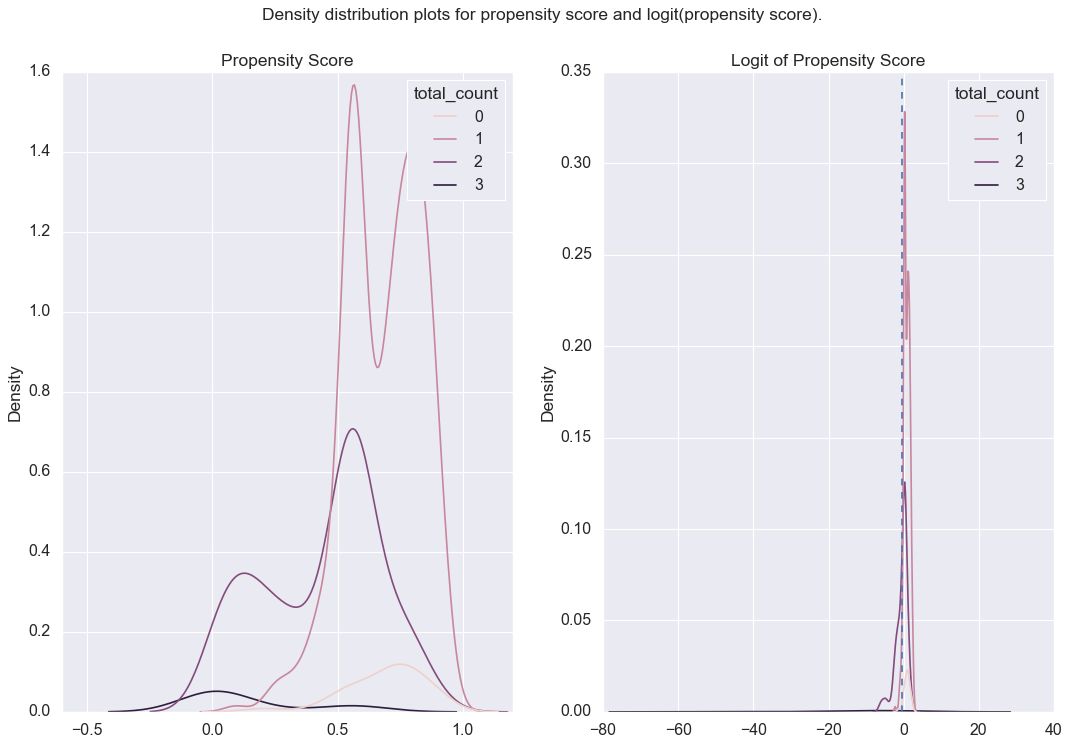

In [140]:
# Density distribution of propensity score (logic) broken down by treatment status
fig, ax = plt.subplots(1,2)
fig.suptitle('Density distribution plots for propensity score and logit(propensity score).')
sns.kdeplot(x = predictions[:,1], hue = T , ax = ax[0])
ax[0].set_title('Propensity Score')
sns.kdeplot(x = predictions_logit, hue = T , ax = ax[1])
ax[1].axvline(-0.4, ls='--')
ax[1].set_title('Logit of Propensity Score')
plt.show()

In [141]:
# Currently this does not affect the results as all observations fall within this range.
common_support = (predictions_logit > -10) & (predictions_logit < 10)

In [142]:
full_dataset_confounders_2014.loc[:,'propensity_score'] = predictions[:,1]
full_dataset_confounders_2014.loc[:,'propensity_score_logit'] = predictions_logit
full_dataset_confounders_2014.loc[:,'outcome'] = y.TOTAL_QUANTITY

X.loc[:,'propensity_score'] = predictions[:,1]
X.loc[:,'propensity_score_logit'] = predictions_logit
X.loc[:,'outcome'] = y.TOTAL_QUANTITY
X.loc[:,'treatment'] = full_dataset_confounders_2014.total_count_bin

Matching implementation

In [143]:
caliper = np.std(full_dataset_confounders_2014.propensity_score) * 0.25

print('\nCaliper (radius) is: {:.4f}\n'.format(caliper))

df_data = X

knn = NearestNeighbors(n_neighbors=10 , p = 2, radius=caliper)
knn.fit(df_data[['propensity_score_logit']].to_numpy())


Caliper (radius) is: 0.0578



NearestNeighbors(n_neighbors=10, radius=0.05782418081880943)

In [144]:
# Common support distances and indexes
distances , indexes = knn.kneighbors(
    df_data[['propensity_score_logit']].to_numpy(), \
    n_neighbors=10)

In [145]:
print('For item 0, the 4 closest distances are (first item is self):')
for ds in distances[0,0:4]:
    print('Element distance: {:4f}'.format(ds))
print('...')

For item 0, the 4 closest distances are (first item is self):
Element distance: 0.000000
Element distance: 0.006134
Element distance: 0.006598
Element distance: 0.034455
...


In [146]:
print('For item 0, the 4 closest indexes are (first item is self):')
for idx in indexes[0,0:4]:
    print('Element index: {}'.format(idx))
print('...')

For item 0, the 4 closest indexes are (first item is self):
Element index: 0
Element index: 414
Element index: 341
Element index: 161
...


In [147]:
import networkx as nx

In [148]:
G = nx.Graph()

In [149]:
G.add_nodes_from(df_data.reset_index()['osward'].tolist())

In [28]:
G

In [151]:
df_data_no_index = df_data.reset_index()
epsilon = 0.0001
for index, row in df_data_no_index.iterrows():
    other_rows = df_data_no_index[df_data_no_index['treatment'] != row.treatment]
    for o_index, o_row in other_rows.reset_index().iterrows():
        modified_distance = (abs(row.propensity_score_logit - o_row.propensity_score_logit) + epsilon) / abs(row.treatment - o_row.treatment)
        if not G.has_edge(row.osward, o_row.osward):
            G.add_edge(row.osward, o_row.osward, weight=modified_distance)


In [152]:
from networkx.algorithms.tree.branchings import maximum_branching



In [153]:
edmonds_applied = maximum_branching(G)

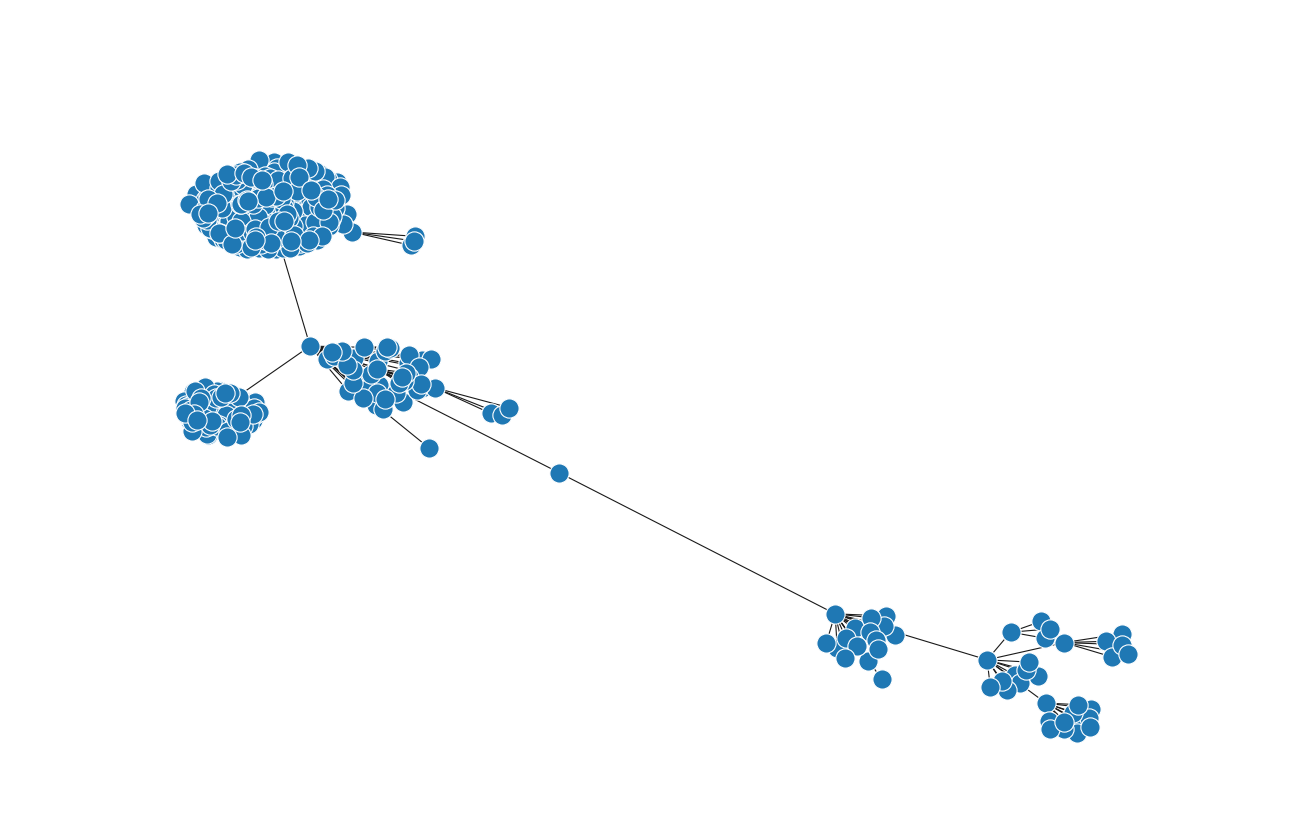

In [154]:
# pos = nx.random_layout(edmonds_applied)
nx.draw(edmonds_applied)

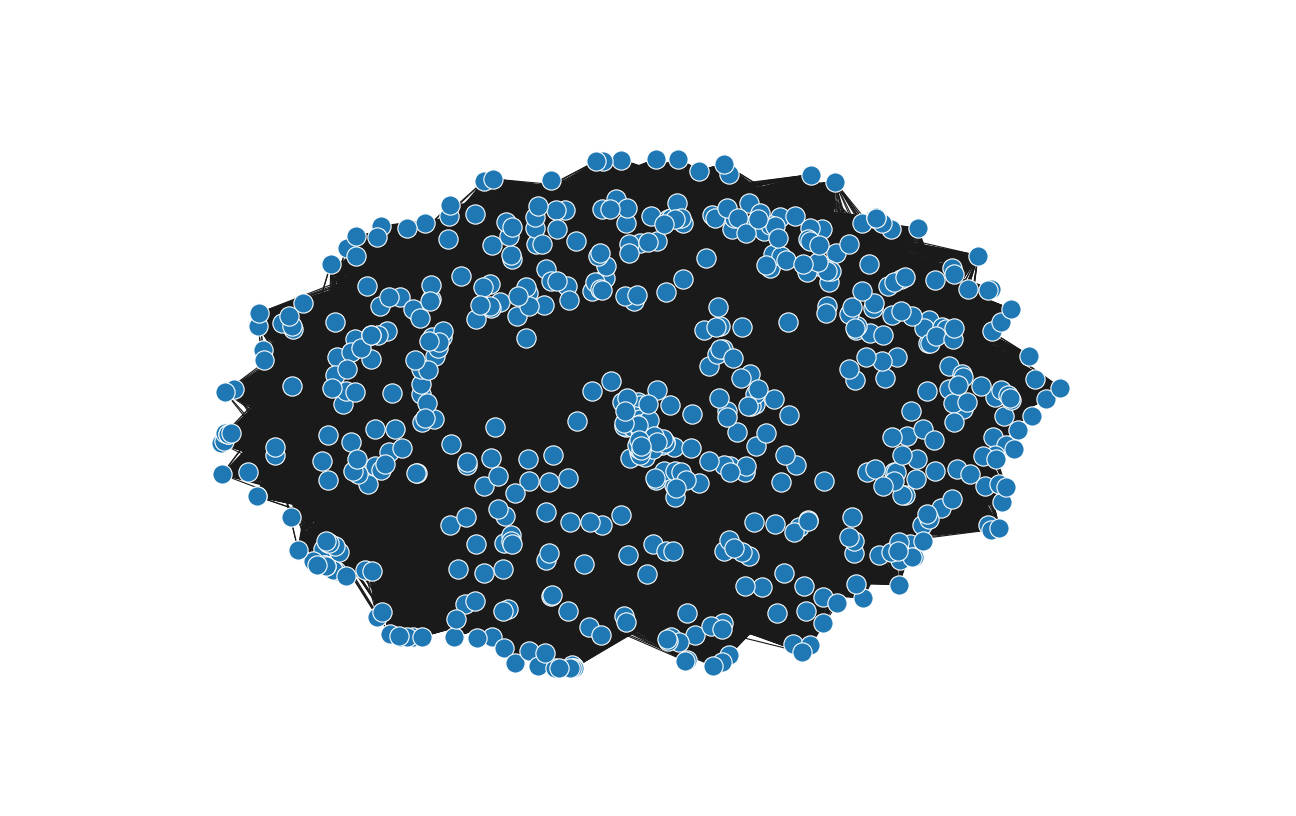

In [89]:
nx.draw(G)

Spearman correlation: 0.05106723267395223 p-value: 0.22225841545671005


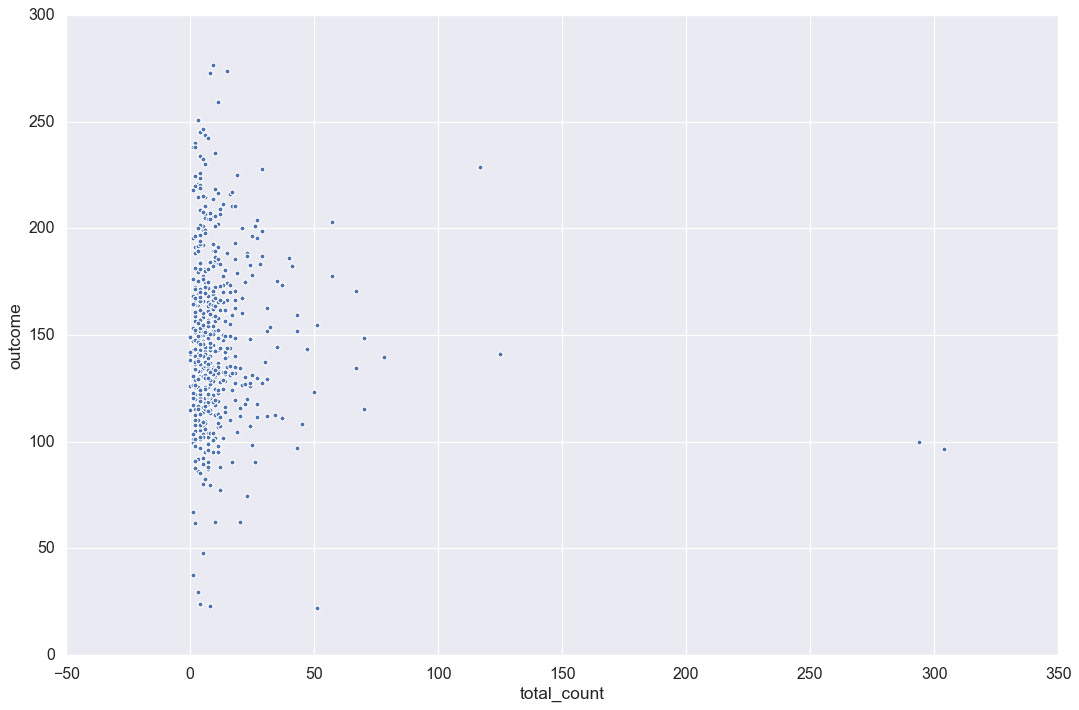

In [163]:
import scipy.stats as stats
from sklearn import preprocessing

correlation = full_dataset_confounders_2014[['total_count', 'outcome']]
correlation.plot.scatter(x='total_count', y='outcome')
spear_corr = stats.spearmanr(list(correlation['total_count']), list(correlation['outcome']))
print('Spearman correlation:', spear_corr.correlation, 'p-value:', spear_corr.pvalue)

In [91]:
df_data

,"('Population and Age; Age structure (percentage) - 2013; Aged 0-15', 'Aged 0-15')","('Population and Age; Age structure (percentage) - 2013; Aged 16-64', 'Aged 16-64')","('Population and Age; Age structure (percentage) - 2013; Aged 65+', 'Aged 65+')","('Workplace employment; Number of Full-time employees; 2013', '2013')","('Workplace employment; Number of Part-time employees; 2013', '2013')","('Access to green space and nature; % area that is greenspace; 2014', '2014')","('Access to green space and nature; % homes with deficiency in access to nature; 2012', '2012')","('Benefits claimants; DWP Working-age client group (rates); 2014', '2014')","('Benefits claimants; Employment and support allowance claimants; 2014', '2014')","('Benefits claimants; Housing Benefit rates; 2014', '2014')","('Benefits claimants; Income Support Claimants; 2014', '2014')","('Benefits claimants; Incapacity Benefit Claimants; 2014', '2014')","('Jobseekers Allowance; JSA Claimant Rate; 2014', '2014')",propensity_score,propensity_score_logit,outcome,treatment
osward,,,,,,,,,,,,,,,,,
E05000026,25.274725,69.963370,5.128205,6300.0,3000.0,21.908601,2.164412,15.1,415.0,18.747475,255.0,75.0,6.236244,0.499330,-0.002681,101.766132,2
E05000027,25.961538,63.461538,10.576923,500.0,500.0,20.621849,71.727362,20.7,490.0,19.271523,335.0,115.0,5.369551,0.895707,2.150404,101.464200,0
E05000028,24.896266,66.390041,9.128631,600.0,700.0,1.885448,17.166271,17.8,535.0,16.010204,290.0,105.0,5.981075,0.745641,1.075496,153.201105,0
E05000029,24.137931,60.591133,15.270936,1000.0,800.0,55.974507,63.592351,19.4,370.0,15.653333,265.0,85.0,5.201417,0.919792,2.439526,154.858463,1
E05000030,20.283019,65.094340,14.622642,3100.0,900.0,50.434179,0.000000,14.7,320.0,12.368098,185.0,70.0,4.638395,0.815196,1.484133,127.256359,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E05011485,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.561059,0.245461,108.809023,2
E05011486,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.561059,0.245461,137.571887,1
E05011487,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.561059,0.245461,194.138889,1


In [94]:
distances = []
treatment_effect = []
for (u,v) in edmonds_applied.edges():
    distances.append(abs(df_data['treatment'][u] - df_data['treatment'][v]))
    effect = (df_data['outcome'][u] - df_data['outcome'][v])/(df_data['treatment'][u] - df_data['treatment'][v])
    treatment_effect.append(effect)

distribution_data = pd.DataFrame(list(zip(distances,treatment_effect)), columns = ['Distance', 'Effect'])

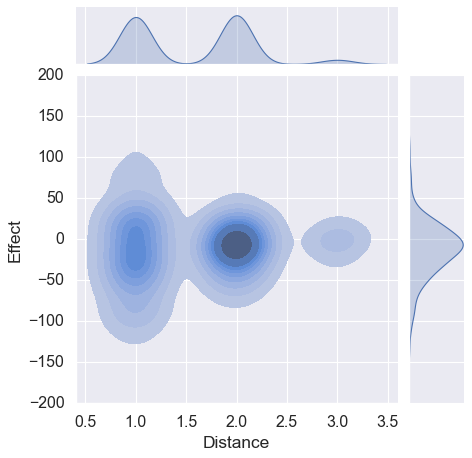

In [95]:
import seaborn as sns

sns.jointplot(distribution_data, x='Distance', y='Effect', kind='kde', fill=True)

In [164]:
from sklearn.metrics import confusion_matrix

low_dose_units = []
high_dose_units = []

for (u,v) in edmonds_applied.edges():
    u_treatment = df_data['treatment'][u]
    v_treatment = df_data['treatment'][v]
    if u_treatment > v_treatment:
        low_dose_units.append(v_treatment)
        high_dose_units.append(u_treatment)
        continue
    low_dose_units.append(u_treatment)
    high_dose_units.append(v_treatment)

confusion_matrix(high_dose_units, low_dose_units)

array([[  0,   0,   0,   0],
       [  1,   0,   0,   0],
       [  2,  72,   0,   0],
       [ 24, 277, 196,   0]], dtype=int64)